In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    

def trend(time, slope = 0):
    return slope*time


def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                   np.cos(season_time *2 *np.pi),
                   1/np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase = 0):
    season_time = ((time+phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [4]:
time = np.arange(4*365 +1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [5]:
series = baseline + trend(time, slope) + seasonality (time, 
                                                     period= 365,
                                                     amplitude = amplitude)

In [6]:
series += noise(time, noise_level, seed = 42)

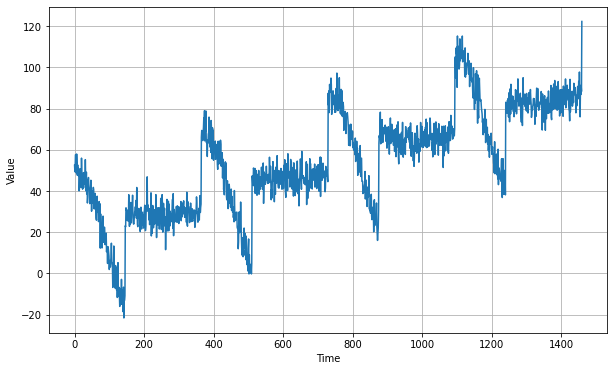

In [7]:
plt.figure(figsize = (10,6))
plot_series(time, series)
plt.show()

In [8]:
split_time = 1000

In [9]:
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size +1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Dense(1, input_shape = [window_size])

model = tf.keras.models.Sequential([l0])

model.compile(loss = "mae", optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9))

In [18]:
model.fit(dataset, epochs = 100, verbose = 0)

print("Layer Weights: {}".format(l0.get_weights()))

Layer Weights: [array([[ 0.45342582],
       [-0.40475214],
       [-0.40894368],
       [-0.22929503],
       [-0.00773855],
       [ 0.18114294],
       [ 0.23407714],
       [ 0.076015  ],
       [-0.06187565],
       [ 0.12377247],
       [-0.17547995],
       [-0.19877681],
       [ 0.35307324],
       [ 0.3144614 ],
       [ 0.16621578],
       [ 0.40235323],
       [-0.3916181 ],
       [ 0.10583955],
       [ 0.40790755],
       [ 0.04750775]], dtype=float32), array([-0.00029566], dtype=float32)]


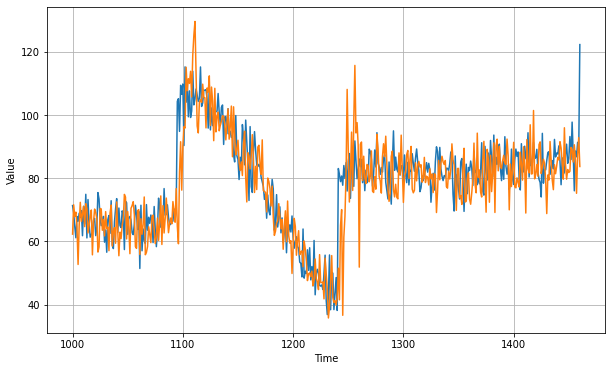

In [29]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [30]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.1628327